# AdaHessian with Imagenette and ImageWoof

In [1]:
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [3]:
def get_dls(size=128):
    dls = ImageDataLoaders.from_folder(path, valid='val', 
        item_tfms=[RandomResizedCrop(size, min_scale=0.35),FlipItem(p=0.5)],  # Resize(size)
        batch_tfms=Normalize.from_stats(*imagenet_stats)) 
    return dls

dls = get_dls(size=128)

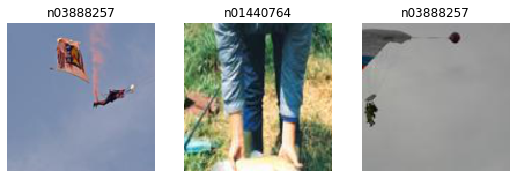

In [4]:
dls.show_batch(max_n=3)

In [5]:
def run_learn(runs=1, epochs=5, lr=1e-3, opt=Adam):
    acc_ls=[]
    for i in range(runs):
        print(f'Run {i}')
        learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=opt, 
                        loss_func=LabelSmoothingCrossEntropy())
        learn.fit_one_cycle(epochs, lr)
        acc_ls.append(learn.final_record[2])
    print(f'Mean accuracy for {runs} runs: {np.mean(acc_ls)} ±{np.std(acc_ls)}')

## Adam Baseline

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0005754399462603033)

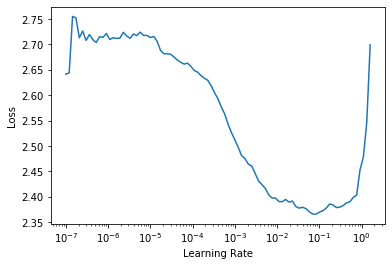

In [6]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=Adam, 
                        loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

5e

In [8]:
run_learn(runs=5, epochs=5, lr=1e-3)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.741036,1.713553,0.517962,00:10
1,1.429281,1.452766,0.611720,00:10
2,1.276610,1.213315,0.715414,00:10
3,1.132250,1.129891,0.749045,00:10
4,1.047501,1.075659,0.766624,00:10


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.731384,1.789632,0.447643,00:11
1,1.426849,1.379277,0.646624,00:10
2,1.253680,1.254361,0.696815,00:10
3,1.123540,1.097470,0.765605,00:10
4,1.035863,1.061290,0.780382,00:10


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.767569,1.780861,0.498344,00:10
1,1.426389,1.554449,0.587771,00:10
2,1.252571,1.282648,0.689172,00:10
3,1.128250,1.106241,0.754395,00:11
4,1.052218,1.063728,0.775032,00:10


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.753409,1.885290,0.434140,00:10
1,1.434894,1.355057,0.645350,00:10
2,1.244235,1.214732,0.712866,00:10
3,1.109569,1.084245,0.762548,00:10
4,1.041392,1.049542,0.782420,00:10


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.777807,1.849087,0.444841,00:10
1,1.436461,1.471607,0.601019,00:10
2,1.257256,1.241354,0.685605,00:10
3,1.137333,1.129292,0.740892,00:10
4,1.055009,1.069487,0.772484,00:10


Mean accuracy for 5 runs: 0.7753885388374329 ±0.005652607412376394


20e

In [6]:
run_learn(runs=5, epochs=20, lr=1e-3)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.963417,1.832762,0.440000,00:11
1,1.603798,1.517795,0.582420,00:10
2,1.403220,1.524998,0.567643,00:10
3,1.302510,1.434804,0.631847,00:10
4,1.252455,1.276982,0.689936,00:10
5,1.160212,1.213683,0.720764,00:10
6,1.109132,1.300379,0.662166,00:10
7,1.055210,1.234309,0.718471,00:10
8,1.031698,1.129206,0.736815,00:10
9,0.971087,1.118234,0.754650,00:10


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.971657,1.832496,0.447134,00:10
1,1.596512,1.597630,0.549045,00:10
2,1.382804,1.439581,0.617580,00:10
3,1.287488,1.344457,0.656560,00:10
4,1.233659,1.197144,0.717962,00:10
5,1.170302,1.228127,0.714395,00:10
6,1.107193,1.133425,0.743949,00:10
7,1.053829,1.140784,0.745223,00:10
8,1.016126,1.066653,0.772484,00:10
9,0.987295,1.069945,0.775796,00:10


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.958816,1.838516,0.436433,00:10
1,1.623762,1.539505,0.576051,00:11
2,1.400150,1.665844,0.540637,00:10
3,1.329220,1.544416,0.594904,00:10
4,1.231857,1.281200,0.684841,00:10
5,1.171109,1.261721,0.697834,00:10
6,1.133276,1.204671,0.705732,00:10
7,1.072508,1.098038,0.766369,00:10
8,1.016886,1.067902,0.770191,00:10
9,0.988925,1.084319,0.760764,00:10


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.959245,1.840483,0.440000,00:10
1,1.607394,1.508440,0.583694,00:10
2,1.428951,1.672246,0.549299,00:10
3,1.322508,1.360994,0.648662,00:10
4,1.249032,1.394289,0.633376,00:10
5,1.176568,1.214046,0.717197,00:10
6,1.106895,1.232441,0.694522,00:10
7,1.066192,1.222436,0.715159,00:10
8,1.015342,1.058711,0.779873,00:10
9,0.988156,1.073142,0.771210,00:10


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.943721,1.827442,0.441019,00:10
1,1.591747,1.562563,0.566624,00:10
2,1.399880,1.365102,0.644076,00:10
3,1.301052,1.447879,0.624204,00:10
4,1.234603,1.230349,0.700892,00:10
5,1.157088,1.294398,0.668790,00:10
6,1.112236,1.241134,0.718217,00:10
7,1.043726,1.136410,0.745987,00:10
8,1.013054,1.139695,0.746497,00:10
9,0.972343,1.071257,0.777834,00:10


Mean accuracy for 5 runs: 0.8621656060218811 ±0.003500739985294573


## AdaHessian

In [7]:
from torch.optim.optimizer import Optimizer
from copy import deepcopy

class Adahessian(Optimizer):
    """Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1)
    """

    def __init__(self, params, lr=0.15, betas=(0.9, 0.999), eps=1e-4,
                 weight_decay=0, hessian_power=1, block_length=32):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(
                    betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 1: {}".format(
                    betas[1]))
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError("Invalid Hessian power value: {}".format(hessian_power))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, hessian_power=hessian_power)
        
        self.block_length=block_length
        super(Adahessian, self).__init__(params, defaults)

    def get_trace(self, params, gradsH):
        """
        compute the Hessian vector product with a random vector v, at the current gradient point,
        i.e., compute the gradient of <gradsH,v>.
        :param gradsH: a list of torch variables
        :return: a list of torch tensors
        """

        #params = self.param_groups[0]['params']
        
        #print(params)
        
        v = [torch.randint_like(p, high=2, device='cuda') for p in params]
        for v_i in v:
            v_i[v_i == 0] = -1
            
        #print(len(gradsH[0]), len(params[0]))
        #print(params) 
            
        hvs = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, retain_graph=True)

        #LESSW WORKING
        hutchinson_trace = []
        for hv, vi in zip(hvs, v):
            param_size = hv.size()
            if len(param_size) <= 2:  # for 0/1/2D tensor
                tmp_output = torch.abs(hv * vi)
                hutchinson_trace.append(tmp_output) # Hessian diagonal block size is 1 here.
            elif len(param_size) == 4:  # Conv kernel
                tmp_output = torch.abs(torch.sum(torch.abs(
                    hv * vi), dim=[2, 3], keepdim=True)) / vi[0, 1].numel() # Hessian diagonal block size is 9 here: torch.sum() reduces the dim 2/3.
                hutchinson_trace.append(tmp_output)

#         # AUTHORS CODE
#         hutchinson_trace = []
#         for hv, vi in zip(hvs, v):
#             param_size = hv.size()
#             if len(param_size) <= 1: # for Bias and LN 
#                 tmp_output = torch.abs( hv * vi) # + 0.
#                 hutchinson_trace.append( tmp_output )
#             elif len(param_size) == 2: # Matrix (removed + 0.)
#                 tmp_output1 = torch.abs((hv * vi )).view(-1, self.block_length) # faltten to the N times self.block_length
#                 tmp_output2 = torch.abs(torch.sum(tmp_output1, dim=[1])).view(-1) / float(self.block_length)
#                 tmp_output3 = tmp_output2.repeat_interleave(self.block_length).view(param_size)
#                 hutchinson_trace.append(tmp_output3)

        #print(self)
        self.hutchinson_trace = hutchinson_trace
        
        return hutchinson_trace

    def step(self, gradsH, closure=None):
        """Performs a single optimization step.
        Arguments:
            gradsH: The gradient used to compute Hessian vector product.
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        params = [ps['params'][0] for ps in self.param_groups]
            
        # get the Hessian diagonal
        hut_trace = self.get_trace(params, gradsH)

        #params = [ps['params'][0] for ps in self.param_groups]
#         for group in self.param_groups:
#             for i, p in enumerate(group['params']):
        for i, group in enumerate(self.param_groups):
            
            p = group['params'][0]
        
            if p.grad is None:
                continue

            grad = deepcopy(gradsH[i].data)
            state = self.state[p]

            # State initialization
            if len(state) == 0:
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data)
                # Exponential moving average of Hessian diagonal square values
                state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)

            exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']

            beta1, beta2 = group['betas']

            state['step'] += 1

            # Decay the first and second moment running average coefficient
            exp_avg.mul_(beta1).add_(1 - beta1, grad)
            # plain: exp_avg = (exp_avg * beta1) + (1 - beta1 * grad)
            
            exp_hessian_diag_sq.mul_(beta2).addcmul_(
                1 - beta2, hut_trace[i], hut_trace[i])
            # plain: exp_hessian_diag_sq = (exp_hessian_diag_sq * beta2) + (1 - beta2 * hut_trace[i] * hut_trace[i])
            
            bias_correction1 = 1 - beta1 ** state['step']
            bias_correction2 = 1 - beta2 ** state['step']

            # make the square root, and the Hessian power
            k = group['hessian_power']
            denom = (
                (exp_hessian_diag_sq.sqrt() ** k) / math.sqrt(bias_correction2) ** k).add_(
                group['eps'])

            # make update
            p.data = p.data - \
                group['lr'] * (exp_avg / bias_correction1 / denom + group['weight_decay'] * p.data)
            
        # Zero gradsH
        for h in hut_trace:
            if h.grad is not None:
                print('h yay')
        
        for g in gradsH:
            if g.grad is not None:
                print('g yay')
                g.grad.detach_()
                g.grad.zero_()

        return loss
    
    def zero_grad(self):
        r"""Clears the gradients of all optimized :class:`torch.Tensor` s."""
        for group in self.param_groups:
            for i,p in enumerate(group['params']):
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()
#                 if self.hut_trace[i].grad is not None:
#                     print('yay')
#                     self.hut_trace[i].grad.detach_()
#                     self.hut_trace[i].grad.zero_()


In [8]:
def get_params_grad(model):
    """
    get model parameters and corresponding gradients
    """
    params = []
    grads = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
        grads.append(0. if param.grad is None else param.grad + 0.)
    return params, grads

In [9]:
@patch
def _backward(self:Learner): self.loss.backward(create_graph=True)    # <---- Changed this

@patch
def _step(self:Learner, gradsH): self.opt.step(gradsH)

@patch
def _do_one_batch(self:Learner):
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb) == 0: return
    self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
    if not self.training: return
    self('before_backward')
    self._backward();                                self('after_backward')
    _, gradsH = get_params_grad(self.model)    # <---- For AdaHessian
    self._step(gradsH);                                    self('after_step')
    self.opt.zero_grad()

In [10]:
def adahessian(param_groups, **kwargs):
    return OptimWrapper(Adahessian([{'params': ps, **kwargs} for ps in param_groups]))

In [11]:
adah = partial(adahessian, wd=1e-4, eps=1e-6)

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:136: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.010964781977236271)

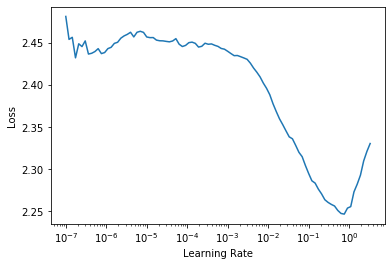

In [11]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy, opt_func=adah, 
                        loss_func=LabelSmoothingCrossEntropy())
learn.lr_find()

In [14]:
run_learn(runs=5, epochs=5, lr=15e-2, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.763534,2.187646,0.439236,00:54
1,1.440363,1.458780,0.620127,00:54
2,1.243767,1.280792,0.685860,00:54
3,1.100197,1.079353,0.770191,00:54
4,1.007384,1.004538,0.803567,00:54


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.712462,1.921183,0.408662,00:54
1,1.455651,1.816439,0.450955,00:54
2,1.260725,1.331311,0.655287,00:54
3,1.098201,1.072302,0.768917,00:54
4,1.004666,1.000589,0.802803,00:54


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.720258,2.148450,0.349554,00:54
1,1.439471,1.643848,0.544713,00:54
2,1.256717,1.270704,0.689427,00:54
3,1.111248,1.053764,0.777070,00:54
4,1.007160,1.002378,0.801019,00:54


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.707694,4.000839,0.241274,00:54
1,1.442774,1.611822,0.567643,00:54
2,1.268786,1.223009,0.708280,00:54
3,1.098616,1.056593,0.776560,00:54
4,0.999284,1.012281,0.796943,00:54


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.745796,2.333215,0.380637,00:54
1,1.462240,1.452385,0.595669,00:54
2,1.271428,1.277293,0.680000,00:54
3,1.127892,1.064256,0.770701,00:54
4,1.021050,1.015442,0.798217,00:54


Mean accuracy for 5 runs: 0.8005095601081849 ±0.002563016871849635


20e

In [12]:
run_learn(runs=5, epochs=20, lr=15e-2, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.772270,1.696438,0.513121,00:54
1,1.507425,1.512272,0.597197,00:54
2,1.389798,1.482218,0.615541,00:54
3,1.306499,1.817895,0.507771,00:54
4,1.206033,1.365303,0.654267,00:54
5,1.125208,1.333951,0.657580,00:54
6,1.071629,1.249965,0.714904,00:54
7,1.032939,1.213565,0.711592,00:54
8,0.985048,1.150225,0.731210,00:54
9,0.967587,1.115329,0.744968,00:54


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.787853,1.669609,0.517707,00:54
1,1.550317,1.745377,0.495032,00:54
2,1.438123,1.886255,0.498089,00:54
3,1.328078,1.627182,0.558726,00:54
4,1.224533,1.565382,0.571465,00:54
5,1.156446,1.173697,0.722038,00:54
6,1.113137,1.144885,0.734013,00:54
7,1.026155,1.112850,0.753885,00:54
8,0.985399,1.120976,0.743694,00:54
9,0.957931,1.025728,0.780127,00:54


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.724278,1.629180,0.538344,00:54
1,1.517566,1.759473,0.495287,00:54
2,1.421471,1.894650,0.487134,00:54
3,1.329647,1.521836,0.556688,00:54
4,1.216735,1.370328,0.654013,00:54
5,1.130151,1.181350,0.724841,00:54
6,1.084928,1.360548,0.632357,00:54
7,1.024759,1.085493,0.764331,00:54
8,0.979230,1.137920,0.749045,00:54
9,0.944336,0.978163,0.806879,00:54


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.749107,1.635239,0.532229,00:54
1,1.526541,1.675902,0.533248,00:54
2,1.394002,2.031899,0.459618,00:54
3,1.326997,1.493066,0.583439,00:54
4,1.215573,1.575603,0.579363,00:54
5,1.142051,1.289049,0.670064,00:54
6,1.081465,1.335954,0.663185,00:54
7,1.034652,1.176640,0.723567,00:54
8,1.015618,1.237811,0.715669,00:54
9,0.959354,1.069210,0.773248,00:54


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.773769,1.664139,0.517962,00:54
1,1.529080,1.843370,0.471592,00:54
2,1.433285,1.793021,0.490191,00:54
3,1.328898,1.540773,0.566624,00:54
4,1.225628,1.694905,0.533248,00:54
5,1.140197,1.292823,0.682293,00:54
6,1.095564,1.144692,0.739108,00:54
7,1.039630,1.133487,0.735541,00:54
8,1.002416,1.074412,0.764076,00:54
9,0.946394,1.041800,0.782166,00:54


Mean accuracy for 5 runs: 0.884178352355957 ±0.0033203217909568766


In [11]:
run_learn(runs=5, epochs=1, lr=15e-2, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.604384,1.458035,0.609682,00:54


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.572952,1.448050,0.607643,00:53


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.576885,1.419331,0.613503,00:53


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.592677,1.431316,0.627261,00:53


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.570758,1.400866,0.637707,00:53


Mean accuracy for 5 runs: 0.6191592335700988 ±0.011524712715869698


In [11]:
run_learn(runs=5, epochs=1, lr=3e-2, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.652814,1.557877,0.573503,00:54


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.632444,1.543209,0.570955,00:53


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.667832,1.568727,0.568153,00:53


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.684695,1.574373,0.571975,00:53


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.620927,1.523391,0.587771,00:53


Mean accuracy for 5 runs: 0.5744713306427002 ±0.0068750224136724354


In [12]:
run_learn(runs=5, epochs=1, lr=2e-1, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.671458,1.494810,0.595159,00:53


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.611567,1.456873,0.605860,00:54


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.559409,1.404699,0.625478,00:54


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.600872,1.451255,0.618089,00:54


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.592809,1.432951,0.620637,00:54


Mean accuracy for 5 runs: 0.6130445957183838 ±0.011037943545737675


In [13]:
run_learn(runs=5, epochs=1, lr=4e-1, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.665512,1.477477,0.593121,00:52


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.660725,1.486587,0.600764,00:53


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.616009,1.449227,0.603822,00:53


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.646343,1.491997,0.594904,00:53


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.620086,1.455671,0.612484,00:53


Mean accuracy for 5 runs: 0.6010191082954407 ±0.006915691325629961


In [14]:
run_learn(runs=5, epochs=1, lr=3e-1, opt=adah)

Run 0


epoch,train_loss,valid_loss,accuracy,time
0,1.596885,1.440555,0.608917,00:53


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.


Run 1


epoch,train_loss,valid_loss,accuracy,time
0,1.578040,1.444553,0.609172,00:53


Run 2


epoch,train_loss,valid_loss,accuracy,time
0,1.600427,1.457849,0.614013,00:53


Run 3


epoch,train_loss,valid_loss,accuracy,time
0,1.601584,1.451050,0.613758,00:53


Run 4


epoch,train_loss,valid_loss,accuracy,time
0,1.620912,1.428176,0.622420,00:53


Mean accuracy for 5 runs: 0.6136560440063477 ±0.004889062473876269
